# 1. Setup

In [0]:
!pip install git+https://github.com/usgs/geomag-algorithms.git
!pip install git+https://github.com/samiriff/mars-ode-data-access.git

  Cloning https://github.com/usgs/geomag-algorithms.git to /tmp/pip-req-build-aem5y8q6
  Running command git clone -q https://github.com/usgs/geomag-algorithms.git /tmp/pip-req-build-aem5y8q6
     |████████████████████████████████| 23.9MB 1.8MB/s 
     |████████████████████████████████| 215kB 44.9MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-v_umwhm5/wheels/dc/8b/cb/0141ac2aa76db65e2037c96bf61b63c26a64a1eb4ddb6f7eeb
  Stored in directory: /root/.cache/pip/wheels/11/d6/40/c448464ae42229b2f9fb46b71be0213e10e9628346b7f1198f
  Stored in directory: /root/.cache/pip/wheels/89/40/f5/7b4f2285aca871b5173887a6c69127210d92806c0d3a977e51
Successfully built geomag-algorithms obspy pycurl
  Cloning https://github.com/samiriff/mars-ode-data-access.git to /tmp/pip-req-build-_680s4a4
  Running command git clone -q https://github.com/samiriff/mars-ode-data-access.git /tmp/pip-req-build-_680s4a4
     |████████████████████████████████| 19.7MB 2.7MB/s 
     |████████████████████████████████| 20.1

In [0]:
from ode_data_access.query_processor import QueryProcessor
from ode_data_access.query_result_processor import QueryResultProcessor
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# 2. Initialize Vectorized Chunks List
- Run the following cell only once, to initialize a list to keep track of all the chunks prepared from multiple queries

In [0]:
vectorized_chunks = []   # Change to None if you only require the folder of images and not an NPZ file

# 3. Query Processing
- Run the following cells multiple times with different query parameters
- Each run will take care of aggregating chunks in the vectorized_chunks list
- Once you have got all the results you require, save the vectorized_chunks list as an NPZ file by going to step 4

In [0]:
# Query Parameters
target = 'mars'  # Aimed planetary body, i.e., Mars, Mercury, Moon, Phobos, or Venus
mission = 'MRO'  # Aimed mission, e.g., MGS or MRO
instrument = 'HIRISE'  # Aimed instrument from the mission, e.g., HIRISE or CRISM
product_type = 'RDRV11'  # Type of product to look for, e.g., DTM or RDRV11
western_lon = 234.24  # Western longitude to look for the data, from 0 to 360
eastern_lon = 234.25  # Eastern longitude to look for the data, from 0 to 360
min_lat = 68.21  # Minimal latitude to look for the data, from -90 to 90
max_lat = 68.22  # Maximal latitude to look for the data, from -90 to 90
product_id = '*160*RED*'  # PDS Product Id to look for, with wildcards (*) allowed
min_ob_time = ''  # Minimal observation time in (even partial) UTC format, e.g., '2017-03-01'
max_ob_time = ''  # Maximal observation time in (even partial) UTC format, e.g., '2017-03-01'
file_name = '*.(JP2|LBL)'  # File name to look for, with wildcards (*) allowed
number_product_limit = 10  # Maximal number of products to return (100 at most)
result_offset_number = 0  # Offset the return products, to go beyond the limit of 100 returned products
remove_ndv = True  # Replace the no-data value as mentionned in the label by np.nan
bin_type = 1 # Type of binning used in image - Bin1 = 0.35 cm/pixel, Bin2 = 2xBin1, Bin4 = 2xBin2

# Chunk Settings
SAVE_DIR_PREFIX = './chunks'
CHUNK_SIZE = 1024
SKIP_BLACK_IMAGES = True  # Set to False to retain all images that contain black pixels

# Default Settings to Align and Crop images with black margins
MAX_BORDER_SIZE = 200   # Border to be checked around the image
SAFETY_MARGIN = 0       # Removes extra pixels from the sides to make sure no black remains
TOLERANCE = 10          # A gray value is more likely to be considered black when you increase the tolerance
ALIGN_AND_CROP_THRESHOLDS = (MAX_BORDER_SIZE, SAFETY_MARGIN, TOLERANCE) # Set to None to prevent alignment and cropping

# Query Result Processing
query_processor = QueryProcessor()
query_results = query_processor.query_files_urls(target, mission, instrument, product_type,
                                                 western_lon, eastern_lon, min_lat, max_lat,
                                                 min_ob_time, max_ob_time, product_id, file_name,
                                                 number_product_limit, result_offset_number)
print("Total Number of Files of all bin types =", len(query_results.keys()))
query_result_processor = QueryResultProcessor()
should_continue = query_result_processor.download(query_results, bin_type)
if should_continue:
  query_result_processor.process(SAVE_DIR_PREFIX, CHUNK_SIZE, SKIP_BLACK_IMAGES, ALIGN_AND_CROP_THRESHOLDS, vectorized_chunks)

Query URL: http://oderest.rsl.wustl.edu/live2/?target=mars&ihid=MRO&iid=HIRISE&pt=RDRV11&westernlon=234.24&easternlon=234.25&minlat=68.21&maxlat=68.22&query=product&results=fp&output=XML&limit=10&offset=0&productid=*160*RED*
Total Number of Files of all bin types = 2
Required Product Names matching the given bin type = {'ESP_016160_2485_RED'}
Total number of images to be downloaded = 1

Do you wish to proceed? [Y/n] y
...99%, 354 MB, 6669 KB/s, 54 seconds passed

1014it [05:14,  3.23it/s]

Number of chunks found: 390
-----
Completed Chunking Process


# 4. Downloading Chunks from Colaboratory

## 4.1 Add all chunks to downloadable archive

In [0]:
!zip -q ./chunks.zip -r {SAVE_DIR_PREFIX}*

In [0]:
files.download('./chunks.zip')

## 4.2 Save All Chunks in NPZ Format

### 4.2.1 Save the vectorized_chunks list in npz format

In [0]:
import glob
import os
import cv2
import pandas as pd
from tqdm import tqdm_notebook as tqdm

chunks = []
chunks_index_map = {}
current_index = 0

directories = glob.glob(f'{SAVE_DIR_PREFIX}_*')
for directory in tqdm(directories):
  files = os.listdir(directory)
  for file in tqdm(files):
    img = mpimg.imread(f'{directory}/{file}')
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    chunks.append(img)
  chunks_index_map[directory.split(f'{SAVE_DIR_PREFIX}_')[-1]] = (current_index, current_index + len(files) - 1)
  current_index += len(files)

In [0]:
np.array(chunks).shape

(390, 1024, 1024)

In [0]:
chunks_index_map

{'ESP_016160_2485_RED': (0, 389)}

In [0]:
pd.DataFrame.from_dict(chunks_index_map, orient='index').reset_index().rename(columns={
    'index': 'Image Name',
    0: 'Start Index',
    1: 'End Index'
}).to_csv('chunks_index_map.csv', index=False)

In [0]:
np.savez_compressed('./all_chunks.npz', np.array(chunks))

### 4.2.2 Test NPZ File

In [0]:
import urllib

In [0]:
npz_file_url = 'https://drive.google.com/open?id=1hL6VOLZBLkK7OKyNt3gFRqi0NcvRWF1E'
chunks_index_map_url = 'https://doc-08-2o-docs.googleusercontent.com/docs/securesc/edemqpabedfirta2rk6n6jdsf244973m/jve3h99j2mpjm7b443nmjnqqjmneg18d/1562068800000/11454254326499328020/11454254326499328020/15zLX0iztkme8SiBzxrtEsm4WFrpBkR_M?e=download'

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!wget {npz_file_url}

--2019-07-02 12:45:10--  https://drive.google.com/open?id=1hL6VOLZBLkK7OKyNt3gFRqi0NcvRWF1E
Resolving drive.google.com (drive.google.com)... 74.125.141.102, 74.125.141.101, 74.125.141.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.141.102|:443... connected.
HTTP request sent, awaiting response... 307 OK
Location: https://drive.google.com/file/d/1hL6VOLZBLkK7OKyNt3gFRqi0NcvRWF1E/view?usp=drive_open [following]
--2019-07-02 12:45:10--  https://drive.google.com/file/d/1hL6VOLZBLkK7OKyNt3gFRqi0NcvRWF1E/view?usp=drive_open
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘open?id=1hL6VOLZBLkK7OKyNt3gFRqi0NcvRWF1E’

open?id=1hL6VOLZBLk     [ <=>                ] 119.34K  --.-KB/s    in 0.009s  

2019-07-02 12:45:10 (12.3 MB/s) - ‘open?id=1hL6VOLZBLkK7OKyNt3gFRqi0NcvRWF1E’ saved [122208]



In [0]:
import urllib
import time
import sys
import numpy as np
import pandas as pd


class MarsDataset:

    def __init__(self, npz_url, chunks_index_map_url):
        self.npz_url = npz_url
        self.chunks_index_map_url = chunks_index_map_url
        self.npz_file = 'all_chunks.npz'
        self.chunks_index_map_file = 'chunks_index_map.csv'
        self.data = None
        self.chunks_index_df = None

        self.download_files()

    def download_files(self):
        if not os.path.exists(self.npz_file):
          urllib.request.urlretrieve(self.npz_url, self.npz_file, reporthook=self.download_progress_callback)
        if not os.path.exists(self.chunks_index_map_url):
          urllib.request.urlretrieve(self.chunks_index_map_url, self.chunks_index_map_file,
                                     reporthook=self.download_progress_callback)

    def read(self):
        self.data = np.load(self.npz_file, allow_pickle=True)
        self.data = self.data[self.data.files[0]]

        self.chunks_index_df = pd.read_csv(self.chunks_index_map_file)
        return self.data, self.chunks_index_df

    def get_chunks_index(self, image_name):
        df = self.chunks_index_df[self.chunks_index_df['Image Name'] == image_name]
        return df['Start Index'].iloc[0], df['End Index'].iloc[0]

    def get_chunks(self, image_name):
        start_index, end_index = self.get_chunks_index(image_name)
        return self.data[start_index: end_index + 1]

    def download_progress_callback(self, count, block_size, total_size):
        global start_time
        if count == 0:
            start_time = time.time()
            return
        duration = time.time() - start_time
        progress_size = int(count * block_size)
        speed = int(progress_size / (1024 * duration))
        percent = min(int(count * block_size * 100 / total_size), 100)
        sys.stdout.write("\r...%d%%, %d MB, %d KB/s, %d seconds passed" %
                       (percent, progress_size / (1024 * 1024), speed, duration))
        sys.stdout.flush()

In [0]:
dataset = MarsDataset('https://files.slack.com/files-pri/TJRDXSH3L-FKW4WKQF3/download/all_chunks.npz?pub_secret=c658c7ac54', 
                      'https://files.slack.com/files-pri/TJRDXSH3L-FL2F89THN/download/chunks_index_map.csv')
dataset

...-9830400%, 0 MB, 1817 KB/s, 0 seconds passed

In [0]:
data, chunks_index_df = dataset.read()

In [0]:
print(data.shape)
chunks_index_df

(390, 1024, 1024)


,Image Name,Start Index,End Index
0,ESP_016160_2485_RED,0,389


In [0]:
data = dataset.get_chunks('ESP_016160_2485_RED')
data.shape

(389, 1024, 1024)

(1024, 1024)


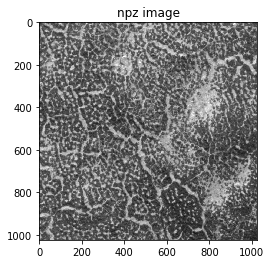

In [0]:
img=data[-1]
print(img.shape)
plt.title('npz image')
plt.imshow(img, cmap='gray')

### 4.2.3 Download NPZ File

In [0]:
files.download('./all_chunks.npz')

# Testing

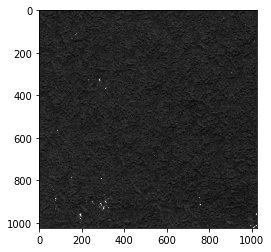

In [0]:
plt.imshow(mpimg.imread('./chunks_ESP_016793_2485_RED/ESP_016793_2485_RED_img_row_6144_col_17408_w_1024_h_1024_x_0_y_0.jpg'), cmap='gray')

# Extras

## Converting Landing Site Coordinates to Planetocentric Coordinates that can be understood by ODE

In [0]:
import pandas as pd
import re

In [0]:
def convert_latitude(latitude):
  value, direction = latitude.split(' ')
  return value if direction == 'N' else -float(value)

In [0]:
def convert_longitude(longitude):
  value, direction = longitude.strip().split(' ')
  value = float(value)
  if direction == 'W':
    value = 360 - value
  return value

In [0]:
with open('../Landing_sites.csv', 'r') as f:
  lines = f.readlines()
  formatted_lines = []
  regex = re.compile(".*?\((.*?)\)")
  for line in lines:
    formatted_line = line.strip()
    formatted_line = re.sub("[\(\[].*?[\)\]]", "", formatted_line)
    formatted_lines.append(formatted_line.split(', '))
    
landing_sites = pd.DataFrame(formatted_lines, columns=['Mission', 'Latitude', 'Longitude', 'Status'])
landing_sites['Latitude'] = landing_sites['Latitude'].apply(convert_latitude)
landing_sites['Longitude'] = landing_sites['Longitude'].apply(convert_longitude)
landing_sites

,Mission,Latitude,Longitude,Status
0,Mars 2,-45,47.000000,Failed
1,Mars 3,-45,202.000000,Failed
2,Mars 6,-23.9,340.580000,Failed
3,Viking 1,22.48,310.030000,Successful
4,Mars Polar Lander,-76.57,165.200000,Failed
5,Pathfinder,19.33,326.450000,Successful
6,Beagle 2,10.6,90.000000,Failed
7,Spirit,-14.5719,175.478480,Successful
8,Opportunity,-1.9462,354.473400,Successful
9,Phoenix,68.218830,234.250778,Successful


In [0]:
landing_sites.to_csv('./landing_sites_ode_coordinates.csv')